<a href="https://colab.research.google.com/github/Rique3012/TransCal2/blob/main/Cilindro_Transferencia_Calor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regime Permanente

(200, 200)


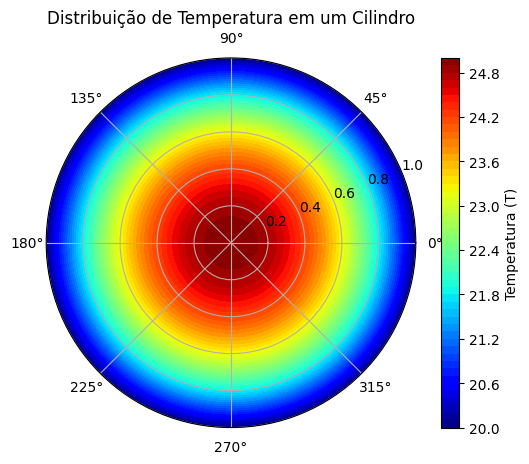

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 10     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
num_points = 200  # Número de pontos no diâmetro do fio

# Função para calcular a temperatura
def calculate_temperature(r, T0, S, R, K):
    return T0 + (S * R**2 / (4 * K)) * (1 - (r / R)**2)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)
T = calculate_temperature(r, T0, S, R, K)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Convertendo para coordenadas cartesianas
X = r * np.cos(theta)
Y = r * np.sin(theta)

# Mapeando as temperaturas para o grid
T_grid = calculate_temperature(r, T0, S, R, K)
print(np.shape(T_grid))

# Configurar o plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.contourf(theta, r, T_grid, 50, cmap=cm.jet)
fig.colorbar(c, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
plt.show()


# Regime Transiente

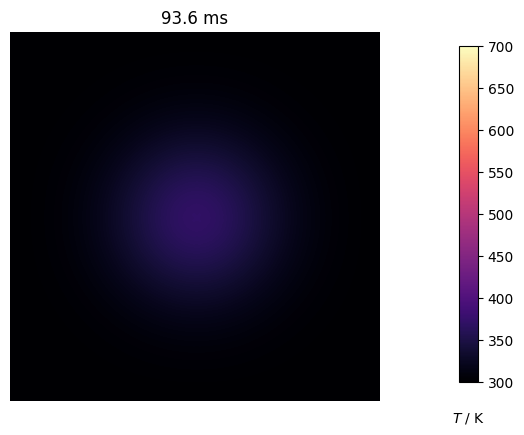

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# plate size, mm
w = h = 10.
# intervals in x-, y- directions, mm
dx = dy = 0.1
# Thermal diffusivity of steel, mm2.s-1
D = 4.

Tcool, Thot = 300, 700

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

# Initial conditions - ring of inner radius r, width dr centred at (cx,cy) (mm)
r, dr, cx, cy = 0, 1, 5, 5
ri2, ro2 = r**2, (r+dr)**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if ri2 < p2 < ro2:
            u0[i,j] = Thot

def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 500
fig = plt.figure()
ax = fig.add_subplot()
# The initial image: interpolate for smoothness and use a perceptually uniform
# sequential colourmap.
im = ax.imshow(u0, cmap=plt.get_cmap('magma'), vmin=Tcool, vmax=Thot,
               interpolation='bicubic')
ax.set_axis_off()
ax.set_title('0.0 ms')
# Add in the colourbar on the right.
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)

def animate(i):
    """Advance the simulation and animation by one time step."""
    global u0, u
    u0, u = do_timestep(u0, u)
    ax.set_title('{:.1f} ms'.format(i*dt*150))
    im.set_data(u.copy())

interval = 150*dt
ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False,
                              interval=interval)
ani.save('heat_transfer.gif', writer='pillow')
plt.show(ani)

Funcionou!!!!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 1000     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
alfa = 4   # Difusividade térmica
num_points = 200                    # Número de pontos no diâmetro do fio
dr = R / (num_points)               # Passo de raio
dt = 0.5 * (dr**2) /(4 * alfa)      # Passo de tempo
beta = alfa * dt / (dr**2)          # Parâmetro beta
tempo = 10000 * dt
nsteps = int(tempo / dt)

# Inicialização do array de temperatura
u = T0 * np.ones(num_points)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Cria um tensor de shape = (num_points,num_points,nsteps) para armazenar
# todas as informações da simulação
T = np.tile(u,(num_points,1))
T_tensor =T.copy().reshape((num_points,num_points,1))

tempo_array = np.linspace(0, tempo, nsteps-1)
tempo_tensor = tempo_array.copy().reshape((1,1,nsteps-1))

tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)
print(mapa_temporal.shape)

# Simulação
for k in range(len(tempo_array)):
  u0 = u.copy()

  u[0] = (1 - 4*beta) * u0[0] + 4*beta * u0[1] + (alfa * dt)/K * S
  for i in range(1, num_points - 1):
    u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + (alfa * dt)/K * S

    #T = np.tile(u,(num_points,1))
    mapa_temporal[:, :, k] = np.tile(u, (num_points, 1))
    #mapa_temporal[i,:,k] = u[i]

  #print(f"Temperatura média: {np.average(u)}ºC")

# Seleciona os frames a serem animados
movie_frames = mapa_temporal[:,:,0::50]   #200 frames animados

# Visualização
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
pcm = ax.pcolormesh(theta,r, movie_frames[:,:,0], cmap ='jet', vmin = T0, vmax = 100)
plt.colorbar(pcm, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
#pcm = ax.pcolormesh(T, cmap=plt.cm.jet, vmin=20, vmax=80)

#Define the initialization function for the animation.  In this case, the function returns the first frame
#of the movie animation.
def init():
    pcm.set_array(movie_frames[:,:,0].ravel())
    return pcm,

#Define the animation update function.  In this function, each map image will be updated with the current frame.
def animate(i):
    pcm.set_array(movie_frames[:,:,i].ravel())
    return pcm,

# 200 frames = 10 s * x frames por segundo
# x = 20 frames por segundo // intervalo = 50 ms

#Call the full animation function.  The number of frames is given by the last element of the shape tuple of
#of the movie frames array.  The time interval between each frame is 50 ms, which will show the animated movie
#at 20 fps
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = movie_frames.shape[2], interval = 50)

#Save the animation as an avi movie file.
anim.save('heatmap_animation.gif')

#Display the resulting animated heat map, which shows temperature changes in the plate over time as it cools down.
plt.show()

(200, 200, 10000)


KeyboardInterrupt: 

(201, 201, 10000)


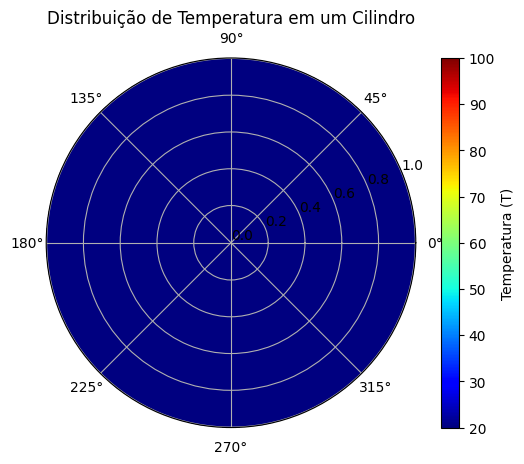

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 1000     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
alfa = 4   # Difusividade térmica
num_points = 201                    # Número de pontos no diâmetro do fio
dr = R / (num_points)               # Passo de raio
dt = 0.5 * (dr**2) /(4 * alfa)      # Passo de tempo
beta = alfa * dt / (dr**2)          # Parâmetro beta
tempo = 10000 * dt
nsteps = int(tempo / dt)

# Inicialização do array de temperatura
u = T0 * np.ones(num_points)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Cria um tensor de shape = (num_points,num_points,nsteps) para armazenar
# todas as informações da simulação
T = np.tile(u,(num_points,1))
T_tensor =T.copy().reshape((num_points,num_points,1))

tempo_array = np.linspace(0, tempo, nsteps-1)
tempo_tensor = tempo_array.copy().reshape((1,1,nsteps-1))

tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)
print(mapa_temporal.shape)

# Simulação
for k in range(len(tempo_array)):
  u0 = u.copy()

  u[0] = (1 - 4*beta) * u0[0] + 4*beta * u0[1] + (alfa * dt)/K
  for i in range(1, num_points - 1):
    if i != 100:
      u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + (alfa * dt)/K
    else:
      u[100] = (beta - beta/(2*100)) * u0[100-1] + (1 - 2*beta) * u0[100] + (beta + beta/(2*100)) * u0[100+1] + (alfa * dt)/K * S

    #T = np.tile(u,(num_points,1))
    mapa_temporal[:, :, k] = np.tile(u, (num_points, 1))
    #mapa_temporal[i,:,k] = u[i]

  #print(f"Temperatura média: {np.average(u)}ºC")

# Seleciona os frames a serem animados
movie_frames = mapa_temporal[:,:,0::50]   #200 frames animados

# Visualização
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
pcm = ax.pcolormesh(theta,r, movie_frames[:,:,0], cmap ='jet', vmin = T0, vmax = 100)
plt.colorbar(pcm, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
#pcm = ax.pcolormesh(T, cmap=plt.cm.jet, vmin=20, vmax=80)

#Define the initialization function for the animation.  In this case, the function returns the first frame
#of the movie animation.
def init():
    pcm.set_array(movie_frames[:,:,0].ravel())
    return pcm,

#Define the animation update function.  In this function, each map image will be updated with the current frame.
def animate(i):
    pcm.set_array(movie_frames[:,:,i].ravel())
    return pcm,

# 200 frames = 10 s * x frames por segundo
# x = 20 frames por segundo // intervalo = 50 ms

#Call the full animation function.  The number of frames is given by the last element of the shape tuple of
#of the movie frames array.  The time interval between each frame is 50 ms, which will show the animated movie
#at 20 fps
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = movie_frames.shape[2], interval = 50)

#Save the animation as an avi movie file.
anim.save('heatmap_animation.gif')

#Display the resulting animated heat map, which shows temperature changes in the plate over time as it cools down.
plt.show()


# Atualiza o plot
# pcm.set_array(T)
# ax.set_title('{:.1f} ms'.format(counter))
# plt.pause(0.01)

# print(T.ravel())
# plt.show()

# interval = 1 * dt
# ani = animation.FuncAnimation(fig, do_timestep(u), frames=nsteps, repeat=False, interval=interval)
# ani.save('heat_transfer.gif', writer='pillow')
# plt.show()








# Mapeando as temperaturas para o grid
#T_grid = np.tile(u0,(num_points,1))

# Configurar o plot
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# c = ax.contourf(theta, r, T_grid, 50, cmap=cm.jet)
# fig.colorbar(c, ax=ax, label='Temperatura (T)')
# ax.set_title('Distribuição de Temperatura em um Cilindro')

# def animate(frame):
#     """Advance the simulation and animation by one time step."""
#     global u0, u
#     u0, u, T_grid = calculate_temperature(u0, u, dr, dt)
#     ax.set_title('{:.1f} ms'.format(frame * dt * 50))
#     c.set_data()
#     return c

# interval = 50 * dt
# ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False, interval=interval)
# ani.save('heat_transfer.gif', writer='pillow')
# plt.show()


<ipython-input-6-5e4fe9d57355>:39: RuntimeWarning: overflow encountered in scalar divide
  utheta = (u0[i, j+1] - 2 * u0[i, j] + u0[i, j-1]) / (r**2 * dtheta2)
<ipython-input-6-5e4fe9d57355>:40: RuntimeWarning: invalid value encountered in scalar add
  u[i, j] = u0[i, j] + D * dt * (ur + utheta + (u0[i+1, j] - u0[i-1, j]) / (2 * r * dr))
<ipython-input-6-5e4fe9d57355>:39: RuntimeWarning: invalid value encountered in scalar subtract
  utheta = (u0[i, j+1] - 2 * u0[i, j] + u0[i, j-1]) / (r**2 * dtheta2)


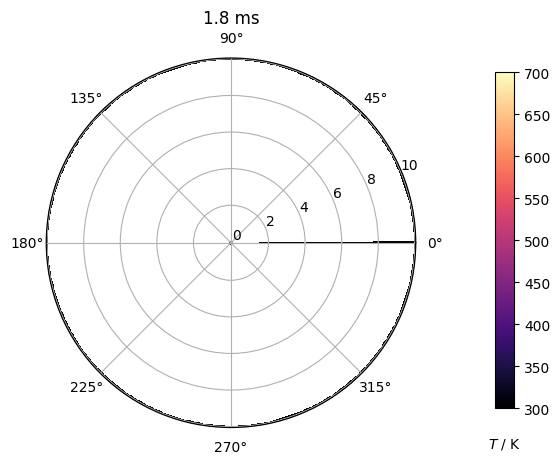

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# cylinder size (radius), mm
r_max = 10.0
# intervals in r, theta directions
dr = 0.1
dtheta = np.pi / 180 # 1 degree intervals
# Thermal diffusivity of steel, mm2.s-1
D = 4.0

Tcool, Thot = 300, 700

nr, ntheta = int(r_max / dr), int(2 * np.pi / dtheta)

dr2 = dr * dr
dtheta2 = dtheta * dtheta
dt = dr2 * dtheta2 / (2 * D * (dr2 + dtheta2))

u0 = Tcool * np.ones((nr, ntheta))
u = u0.copy()

# Initial conditions - ring of inner radius r, width dr
r, dr_initial, cx, cy = 0, 1, 5, 5
ri2, ro2 = r**2, (r + dr_initial)**2
for i in range(nr):
    for j in range(ntheta):
        rad = i * dr
        if ri2 < rad < ro2:
            u0[i, j] = Thot

def do_timestep(u0, u, dr, dtheta, dt, D):
    # Propagate with forward-difference in time, central-difference in space
    for i in range(1, nr-1):
        for j in range(1, ntheta-1):
            r = i * dr
            ur = (u0[i+1, j] - 2 * u0[i, j] + u0[i-1, j]) / dr2
            utheta = (u0[i, j+1] - 2 * u0[i, j] + u0[i, j-1]) / (r**2 * dtheta2)
            u[i, j] = u0[i, j] + D * dt * (ur + utheta + (u0[i+1, j] - u0[i-1, j]) / (2 * r * dr))

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 1000
fig = plt.figure()
ax = fig.add_subplot(polar=True)
# The initial image: interpolate for smoothness and use a perceptually uniform sequential colormap.
r = np.linspace(0, r_max, nr)
theta = np.linspace(0, 2 * np.pi, ntheta)
R, Theta = np.meshgrid(r, theta, indexing='ij')
im = ax.pcolormesh(Theta, R, u0, cmap=plt.get_cmap('magma'), vmin=Tcool, vmax=Thot)
ax.set_title('0.0 ms')
# Add in the colorbar on the right.
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)

def animate(i):
    """Advance the simulation and animation by one time step."""
    global u0, u
    u0, u = do_timestep(u0, u, dr, dtheta, dt, D)
    ax.set_title('{:.1f} ms'.format(i * dt * 50))
    im.set_array(u.copy().ravel())

interval = 50 * dt
ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False, interval=interval)
ani.save('heat_transfer.gif', writer='pillow')
plt.show(ani)


In [ ]:
import numpy as np
a = np.array([0, 1, 2])
#np.tile(a, 2)
np.tile(a, (3, 1))
#np.tile(a, (2, 1, 2))

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [ ]:
import numpy as np
# creating an array
myarray1 = np.array([[1, 2, 3], [4, 5, 6]])

# calling the ravel() function
myarray2 = np.ravel(myarray1, order = "K")

print(myarray2)

# checking the size of the imput and output arrays
print(myarray1.size)
print(myarray2.size)

[1 2 3 4 5 6]
6
6
